# Hyper-parameter Tuning Workflow
Another technique very much worth noting is hyper-parameter tuning, which follows a similar structure to the pre-processor tuning but deals with selecting the best model training parameters for the given data.

Unfortunately there is no rigorous way to predict what parameters will be ideal for a given model or dataset, and thus training (and intuition built up over years of practice) is necessary. Still, we can have the computer run the tuning, even if we need to determine the value's ranges and what precisely to tune.

In [49]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('./*'); sys.path.append('..')
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from trainer import Trainer
import pandas as pd
import os.path as p
import optuna

torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
d = '../sheet_data'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
from datasets.ClassificationSet import ClassificationSet
from models.SheetClassifier import SheetClassifier

# Use the pre-processed images we made in the pre-processing workflow
dataset = ClassificationSet(p.join(d, 'preprocessed_training_set'))
dummy_parameters = SheetClassifier().state_dict()
trainer = Trainer()

In [51]:
#=====
epochs = 15
#=====
results = pd.DataFrame([], columns=['lr', 'wd', 'bs', 'accuracy'])

def objective(trial, learning_rate:float=None, batch_size:float=None, weight_decay:float=None, record:bool=True, show:bool=False):
    lr = trial.suggest_float("lr", 1e-4, 1e-1) if not learning_rate else learning_rate
    batch_size = trial.suggest_categorical("batch_size", [10, 100]) if not batch_size else batch_size
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-1) if not weight_decay else weight_decay

    temp_model = SheetClassifier()
    temp_model.load_state_dict(dummy_parameters)

    trainer.run_experiment(temp_model, dataset, criterion=nn.CrossEntropyLoss,
                           learning_rate=lr, weight_decay=weight_decay, batch_size=batch_size,
                           epochs=epochs, show=show, train_shuffle=False, test_shuffle=False)
    trainer.evaluate_model(temp_model, show=show)

    if record: results.loc[len(results)] = [lr, batch_size, weight_decay, trainer.model_accuracy]
    return trainer.model_accuracy

In [52]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=777))
study.optimize(objective, n_trials=20)

[I 2025-03-12 11:54:53,154] A new study created in memory with name: no-name-113da191-71f9-4267-acb9-97326bd443be
[I 2025-03-12 11:57:41,239] Trial 0 finished with value: 0.5009999871253967 and parameters: {'lr': 0.015351107116642069, 'batch_size': 10, 'weight_decay': 0.0459914355574808}. Best is trial 0 with value: 0.5009999871253967.
[I 2025-03-12 11:59:00,357] Trial 1 finished with value: 0.3529999256134033 and parameters: {'lr': 0.08354181310531908, 'batch_size': 10, 'weight_decay': 0.07685193722984528}. Best is trial 0 with value: 0.5009999871253967.
[I 2025-03-12 11:59:54,613] Trial 2 finished with value: 0.32399997115135193 and parameters: {'lr': 0.026993586140572103, 'batch_size': 10, 'weight_decay': 0.007977791702292179}. Best is trial 0 with value: 0.5009999871253967.
[I 2025-03-12 12:00:29,548] Trial 3 finished with value: 0.5500000715255737 and parameters: {'lr': 0.05900241397024085, 'batch_size': 100, 'weight_decay': 0.0626510558909136}. Best is trial 3 with value: 0.55000

KeyboardInterrupt: 

/tmp/ipykernel_1183720/335759288.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)
/tmp/ipykernel_1183720/335759288.py:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study)
/tmp/ipykernel_1183720/335759288.py:3: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study, params=['lr', 'weight_decay', 'batch_size'])
/tmp/ipykernel_1183720/335759288.py:4: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

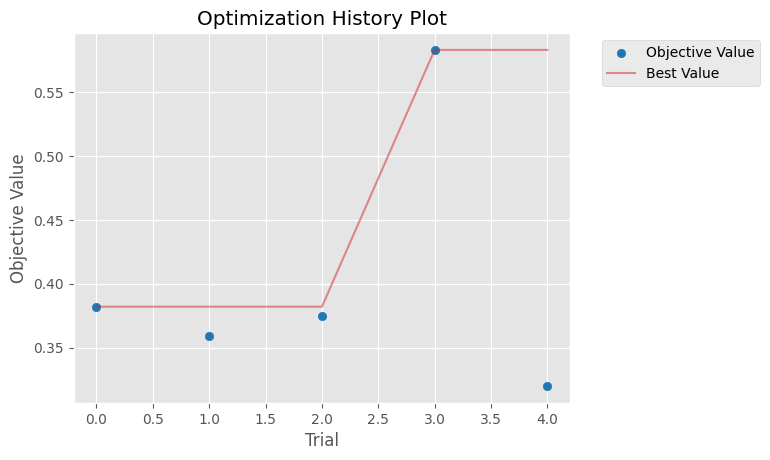

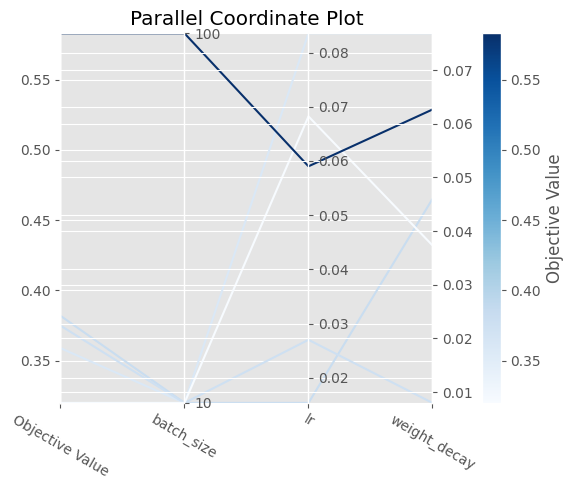

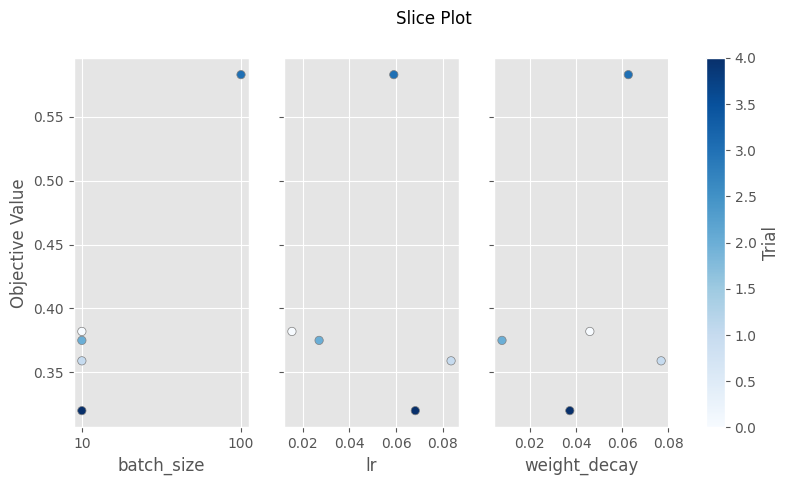

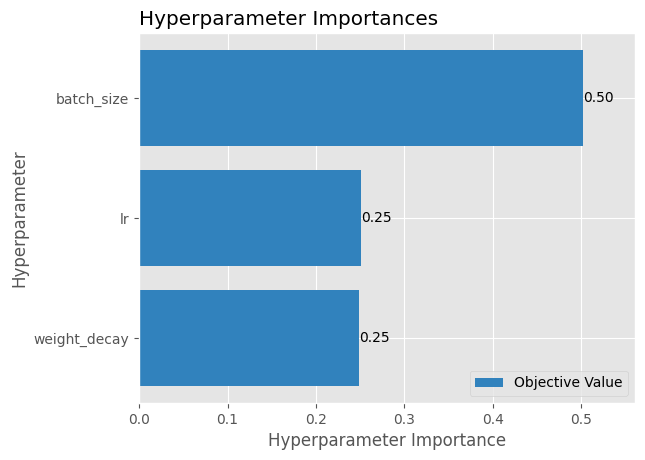

In [20]:
optuna.visualization.matplotlib.plot_optimization_history(study)
optuna.visualization.matplotlib.plot_parallel_coordinate(study)
optuna.visualization.matplotlib.plot_slice(study, params=['lr', 'weight_decay', 'batch_size'])
optuna.visualization.matplotlib.plot_param_importances(study)

In [ ]:
type(study.best_params)

# Utilizing Mixed Precision, LR Scheduling, and Model Pruning

In [47]:
temp_model = SheetClassifier()
temp_model.load_state_dict(dummy_parameters)

trainer.run_experiment(temp_model, dataset, criterion=nn.CrossEntropyLoss,
                        learning_rate=0.1, weight_decay=0.1, batch_size=10,
                        mixed_precision=True, scheduler=True, pruning=False,
                        epochs=25, show=True, train_shuffle=False, test_shuffle=False)
trainer.evaluate_model(temp_model, show=True)

Epoch [1/25], Train Loss: 8.34, Accuracy: 0.49
Epoch [6/25], Train Loss: 1.42, Accuracy: 0.54
Epoch [11/25], Train Loss: 0.91, Accuracy: 0.56
Epoch [16/25], Train Loss: 0.84, Accuracy: 0.61
Epoch [21/25], Train Loss: 0.80, Accuracy: 0.63
Experiment Complete
[Evaluation over 100 Batches], Test Loss: 1.30, Accuracy: 0.41


SheetClassifier(
  (model): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin1): Linear(in_features=16384, out_features=3, bias=True)
)

In [48]:
temp_model = SheetClassifier()
temp_model.load_state_dict(dummy_parameters)

trainer.run_experiment(temp_model, dataset, criterion=nn.CrossEntropyLoss,
                        learning_rate=0.1, weight_decay=0.1, batch_size=10,
                        epochs=25, show=True, train_shuffle=False, test_shuffle=False)
trainer.evaluate_model(temp_model, show=True)

Epoch [1/25], Train Loss: 10.67, Accuracy: 0.47
Epoch [6/25], Train Loss: 2.52, Accuracy: 0.32
Epoch [11/25], Train Loss: 23.85, Accuracy: 0.43
Epoch [16/25], Train Loss: 30.40, Accuracy: 0.44
Epoch [21/25], Train Loss: 8.00, Accuracy: 0.47
Experiment Complete
[Evaluation over 100 Batches], Test Loss: 1.56, Accuracy: 0.38


SheetClassifier(
  (model): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin1): Linear(in_features=16384, out_features=3, bias=True)
)